In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Load and unzip
# !cp "/content/drive/My Drive/Face_Mask_Detection/FMD_DATASET_Split.zip" "dataset"
# !unzip dataset -d data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#importing dependencies related to nn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#importing dependencies related to image transformations
import torchvision
from torchvision import transforms
from PIL import Image

#importing dependencies related to data loading
from torchvision import datasets
from torch.utils.data import DataLoader

#importing Tensorboard for data visualization
from torch.utils.tensorboard import SummaryWriter

from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#defining image transformations

image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [ ]:
# loading data
data = {
    'train':
    datasets.ImageFolder(root='/content/data/FMD_DATASET/Train', transform=image_transforms['train']),
    'test':
    datasets.ImageFolder(root='/content/data/FMD_DATASET/Test', transform=image_transforms['test']),
}

# Dataloader iterators, used for making batches
dataloaders = {
    'train': DataLoader(data['train'], batch_size=100, shuffle=True),
    'test': DataLoader(data['test'], batch_size=100, shuffle=True)
}

In [ ]:
#loading MobileNetv2
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
#freezing the initial layers of MobileNetv2
for param in model.parameters():
    param.requires_grad = False

In [ ]:
print(model)

In [ ]:
#adding our own classifier
model.classifier = nn.Sequential(
                      nn.Linear(1280, 3),
                      nn.LogSoftmax(dim=1))

In [ ]:
# !cp "/content/drive/My Drive/Face_Mask_Detection/Weights/VGG-FaceMDN-epc-38-acc-0.9834070796460177.pth" "Trained_weight.pth"
# model = torch.load('Trained_weight.pth', map_location=lambda storage, loc: storage)
# # #model.load_state_dict(pretrained)

In [ ]:
#checking trainable parameters
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

3843


In [ ]:
#checking GPU Avaibility
if torch.cuda.is_available():
    print('training on GPU')
    device = torch.device("cuda:0")
else:
    print('training on CPU')
    device = torch.device("cpu")

training on GPU


In [ ]:
#training data
from tqdm.notebook import tqdm #for loading bars

def train(model, optimizer, loss_fn, train_loader, val_loader, epochs,device):
    writer = SummaryWriter("saves/logs")
    for epoch in tqdm(range(epochs)):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        num_correct_train = 0
        num_examples_train = 0
        for batch in (train_loader):
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            #print(targets)
            output = model(inputs)
            #print(output)
            loss = loss_fn(output, targets)
            # loss.requires_grad = True
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
            correct_train = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets).view(-1)
            #y_pred.extend(correct.cpu().numpy())
            num_correct_train += torch.sum(correct_train).item()
            num_examples_train += correct_train.shape[0]
        training_loss /= len(train_loader.dataset)

        model.eval()
        num_correct = 0
        num_examples = 0
        y_true = []
        y_pred = []
        for batch in (val_loader):
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            _, predicted = torch.max(output.data, 1)
            # print(predicted)
            targets = targets.to(device)
            y_true.extend(targets.cpu().numpy())
            loss = loss_fn(output,targets)
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets).view(-1)
            y_pred.extend(predicted.cpu().numpy())
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)
        cf_matrix = confusion_matrix(y_true, y_pred)
        #print(cf_matrix)
        class_names = ('incorrect_mask', 'with_mask', 'without_mask')
        # Create pandas dataframe
        dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)
        plt.figure(figsize=(8, 6))

        # Create heatmap
        sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")

        plt.title("Confusion Matrix"), plt.tight_layout()

        plt.ylabel("True Class"),
        plt.xlabel("Predicted Class")
        plt.show()
        print('Epoch: {}, Training Loss: {:.4f}, Train Accuracy = {:.4f}, Validation Loss: {:.4f}, Val Accuracy = {:.4f}'.format(epoch+1, training_loss, num_correct_train / num_examples_train, valid_loss, num_correct / num_examples))

        #save model
        if(training_loss<0.1):
            torch.save(model,"/content/drive/My Drive/Face_Mask_Detection/Weights/Base-Mobile-FaceMDN-epc-"+str(epoch+1)+"-acc-"+str(num_correct / num_examples)+".pth")

        #tensorBoard save log
        writer.add_scalar('Loss', loss.item(), epoch)
        writer.add_scalar('Train/Loss', training_loss, epoch)
        writer.add_scalar('Test/Loss', valid_loss, epoch)
        writer.add_scalar('Test/Accuracy',num_correct / num_examples, epoch)
        writer.flush()

In [ ]:
#testing data
def test_model(model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloaders['test']:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('correct: {:d}  total: {:d}'.format(correct, total))
    print('accuracy = {:f}'.format(correct / total))

In [ ]:
#put model to GPU (if available)
model=model.to(device)

In [ ]:
#choosing optimizer and loss Function
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss()

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


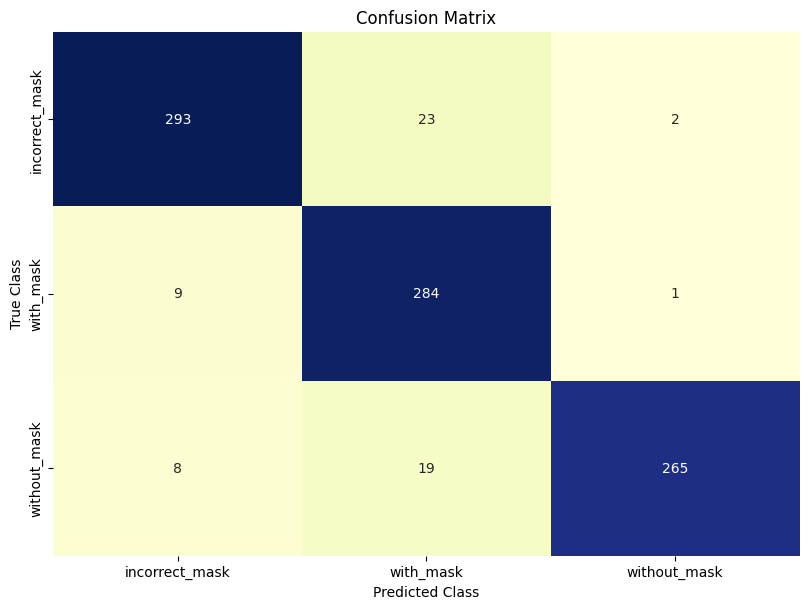

Epoch: 1, Training Loss: 0.3312, Train Accuracy = 0.8905, Validation Loss: 0.2482, Val Accuracy = 0.9314


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


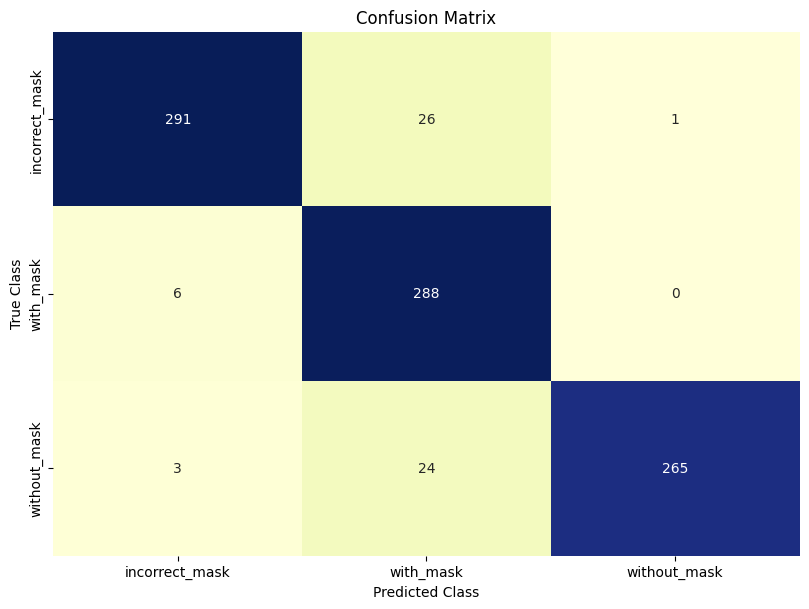

Epoch: 2, Training Loss: 0.1761, Train Accuracy = 0.9492, Validation Loss: 0.2120, Val Accuracy = 0.9336


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


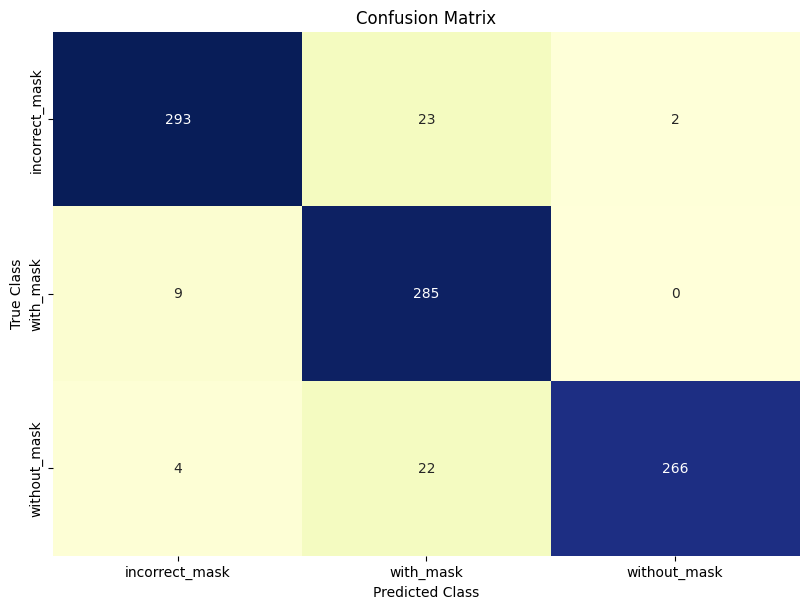

Epoch: 3, Training Loss: 0.1508, Train Accuracy = 0.9551, Validation Loss: 0.1907, Val Accuracy = 0.9336


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


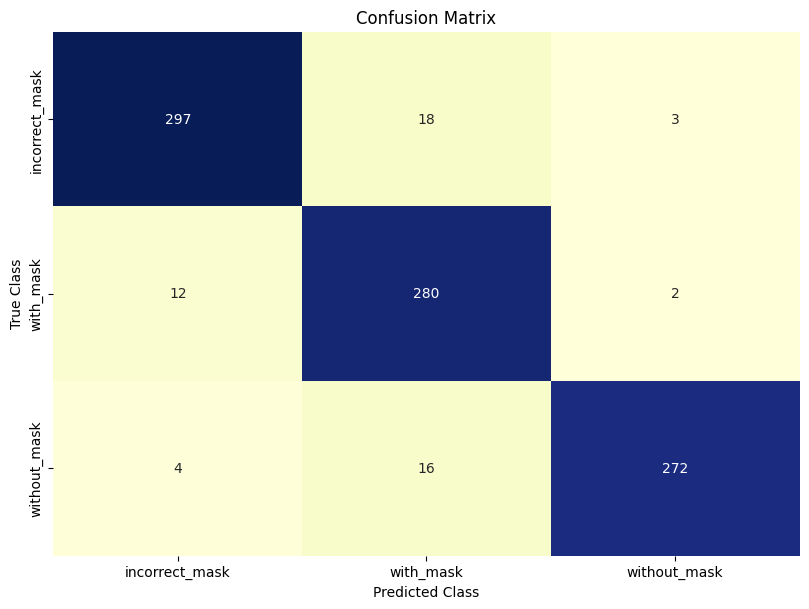

Epoch: 4, Training Loss: 0.1380, Train Accuracy = 0.9553, Validation Loss: 0.1669, Val Accuracy = 0.9392


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


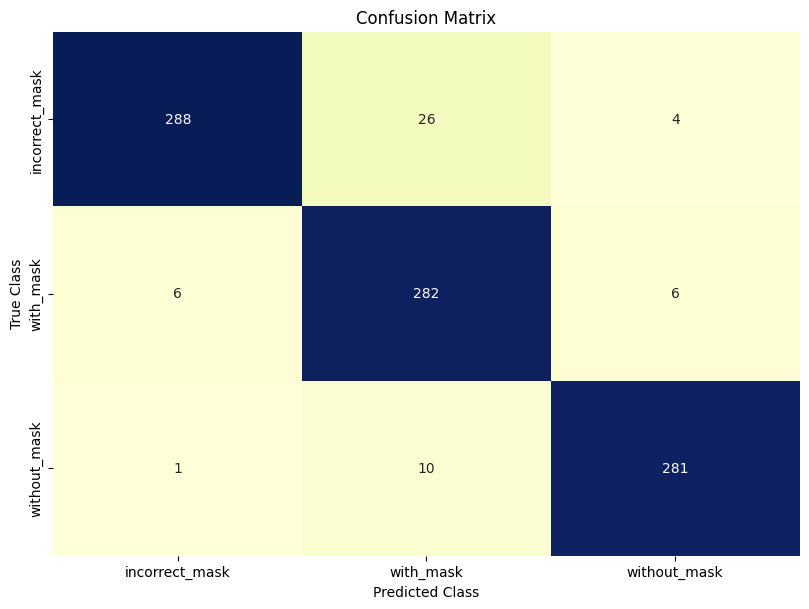

Epoch: 5, Training Loss: 0.1280, Train Accuracy = 0.9580, Validation Loss: 0.1600, Val Accuracy = 0.9414


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


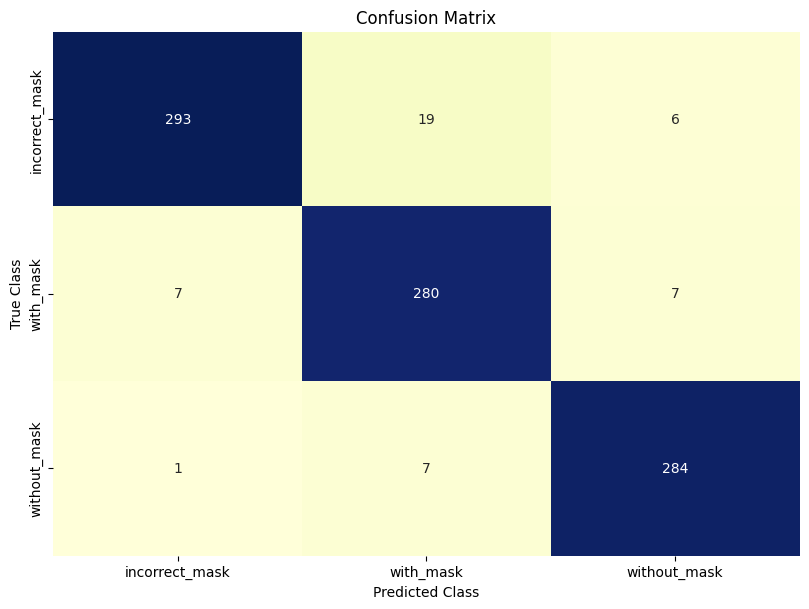

Epoch: 6, Training Loss: 0.1273, Train Accuracy = 0.9585, Validation Loss: 0.1427, Val Accuracy = 0.9480


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


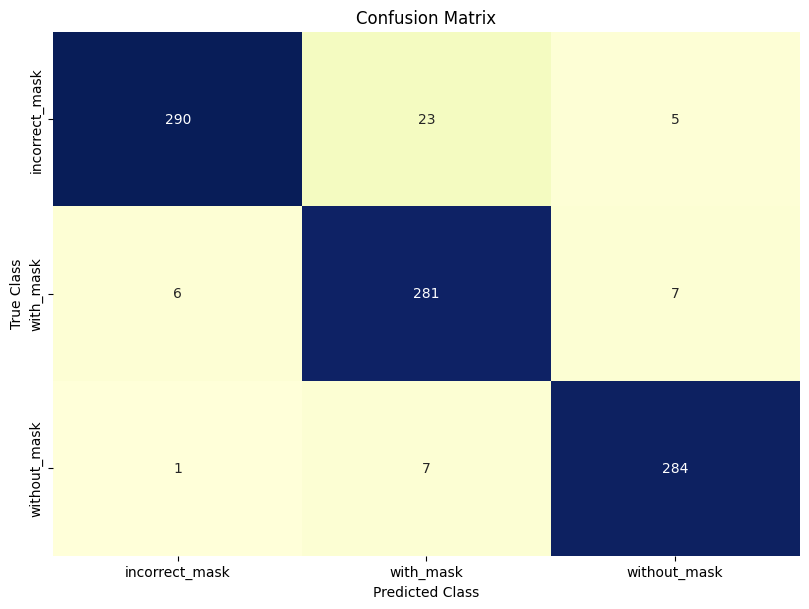

Epoch: 7, Training Loss: 0.1250, Train Accuracy = 0.9583, Validation Loss: 0.1449, Val Accuracy = 0.9458


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


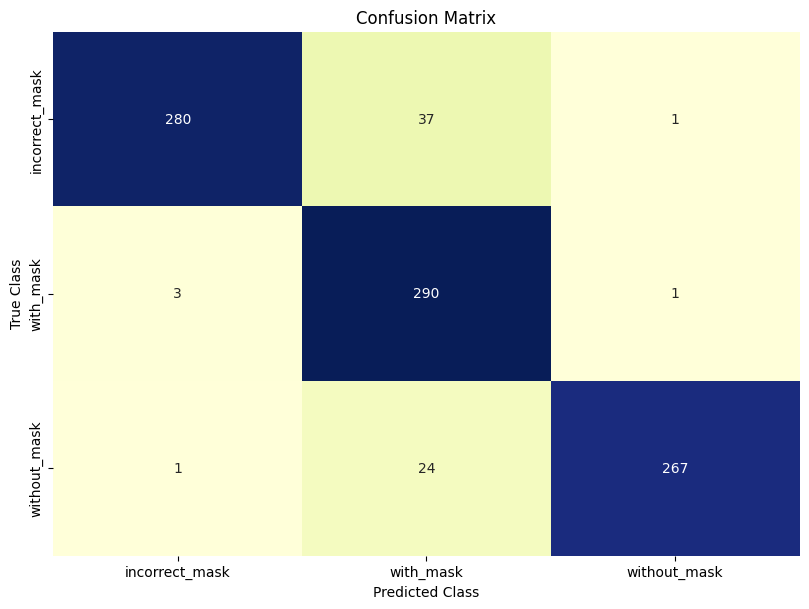

Epoch: 8, Training Loss: 0.1183, Train Accuracy = 0.9615, Validation Loss: 0.1941, Val Accuracy = 0.9259


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


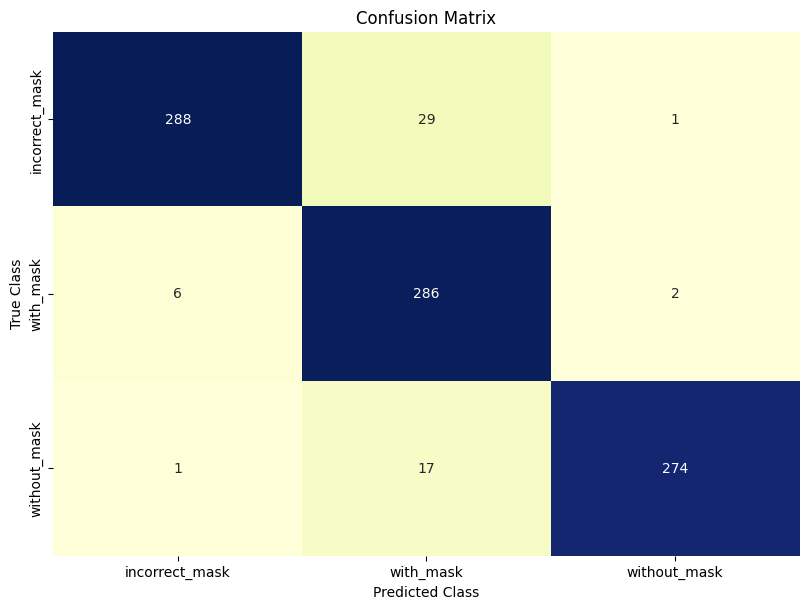

Epoch: 9, Training Loss: 0.1227, Train Accuracy = 0.9588, Validation Loss: 0.1596, Val Accuracy = 0.9381


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


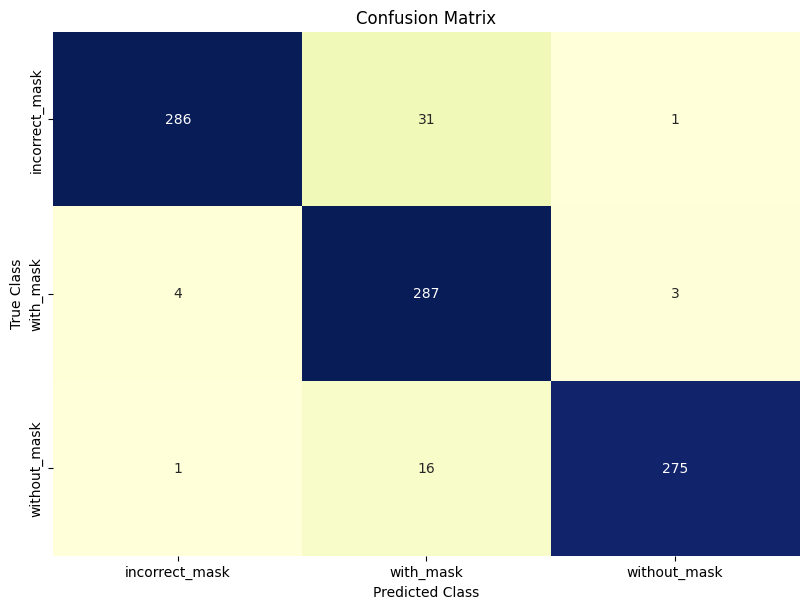

Epoch: 10, Training Loss: 0.1150, Train Accuracy = 0.9617, Validation Loss: 0.1738, Val Accuracy = 0.9381


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


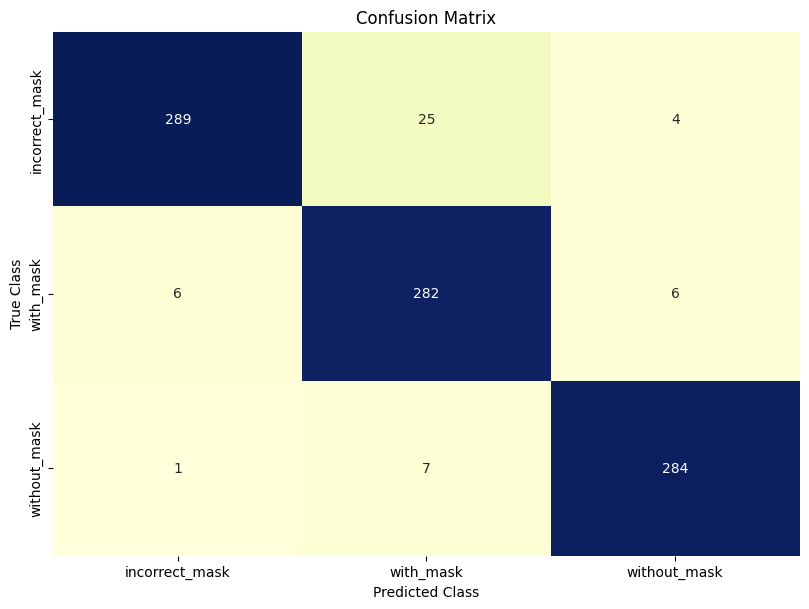

Epoch: 11, Training Loss: 0.1153, Train Accuracy = 0.9604, Validation Loss: 0.1383, Val Accuracy = 0.9458


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


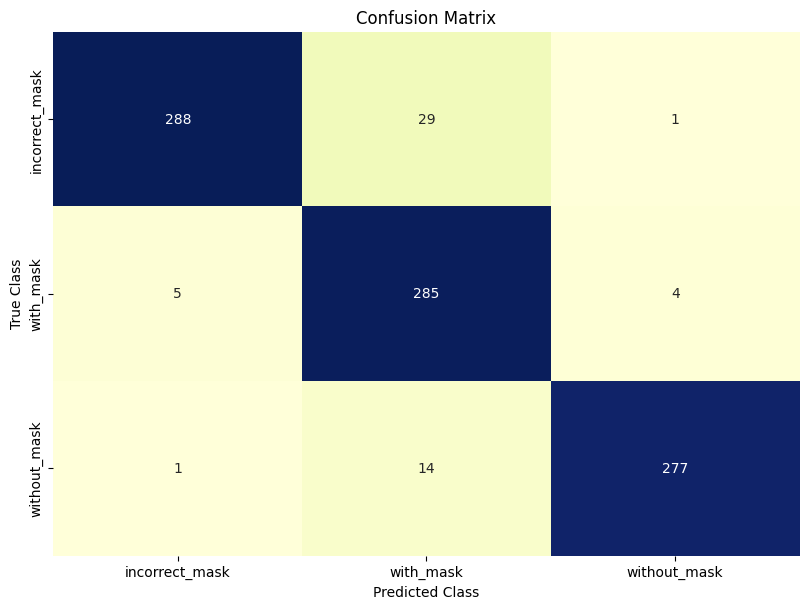

Epoch: 12, Training Loss: 0.1078, Train Accuracy = 0.9632, Validation Loss: 0.1490, Val Accuracy = 0.9403


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


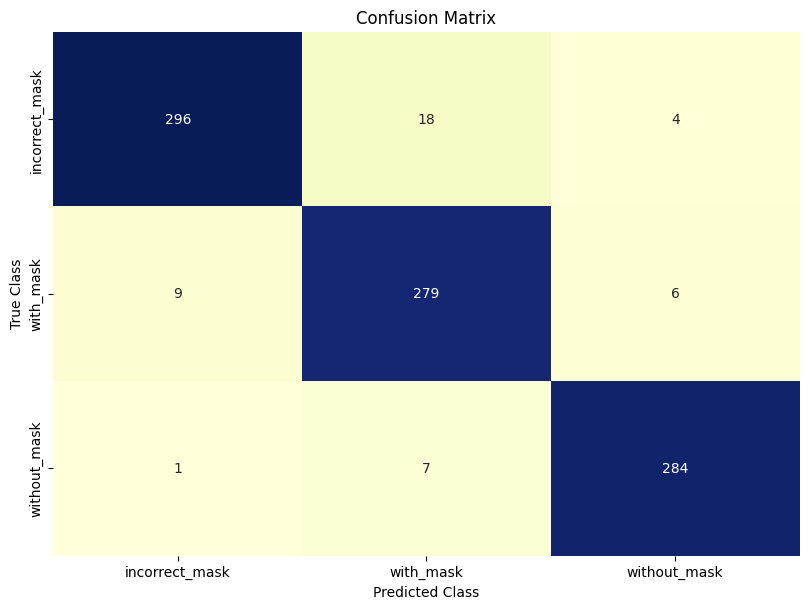

Epoch: 13, Training Loss: 0.1091, Train Accuracy = 0.9628, Validation Loss: 0.1289, Val Accuracy = 0.9502


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


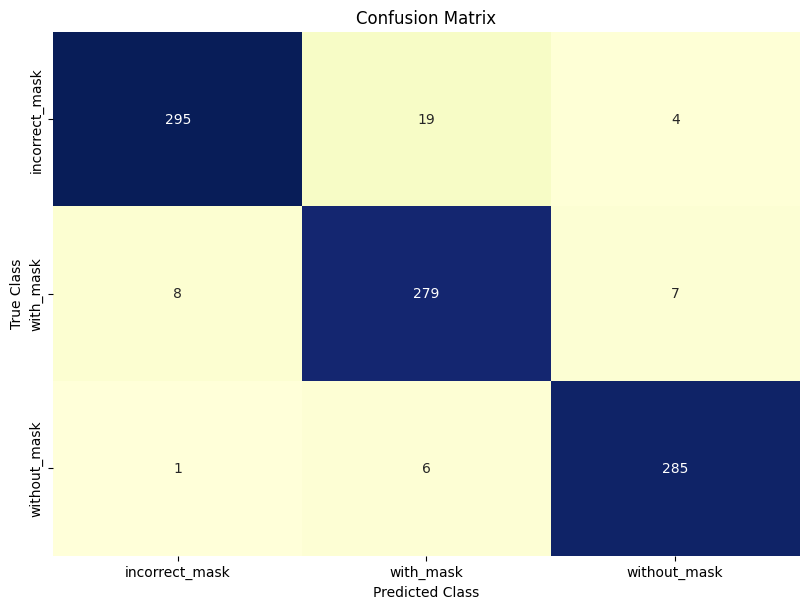

Epoch: 14, Training Loss: 0.1012, Train Accuracy = 0.9666, Validation Loss: 0.1308, Val Accuracy = 0.9502


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


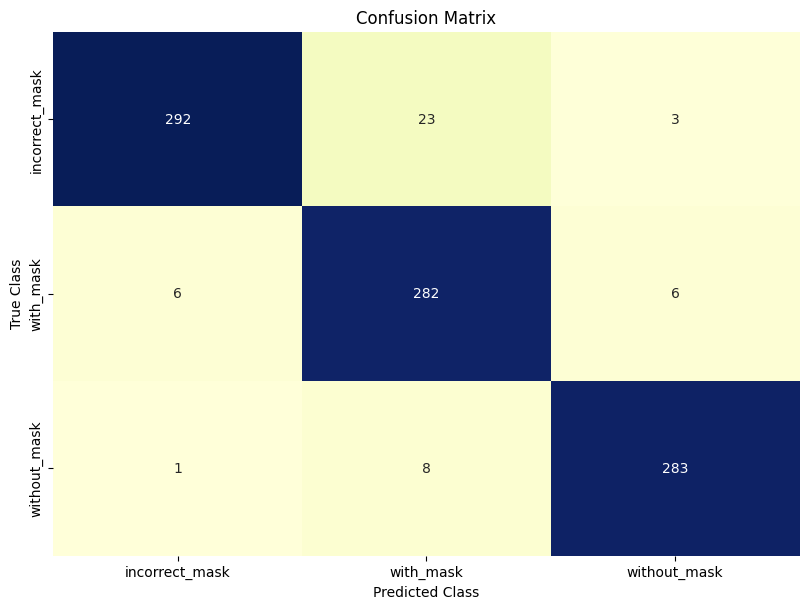

Epoch: 15, Training Loss: 0.1061, Train Accuracy = 0.9651, Validation Loss: 0.1339, Val Accuracy = 0.9480


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


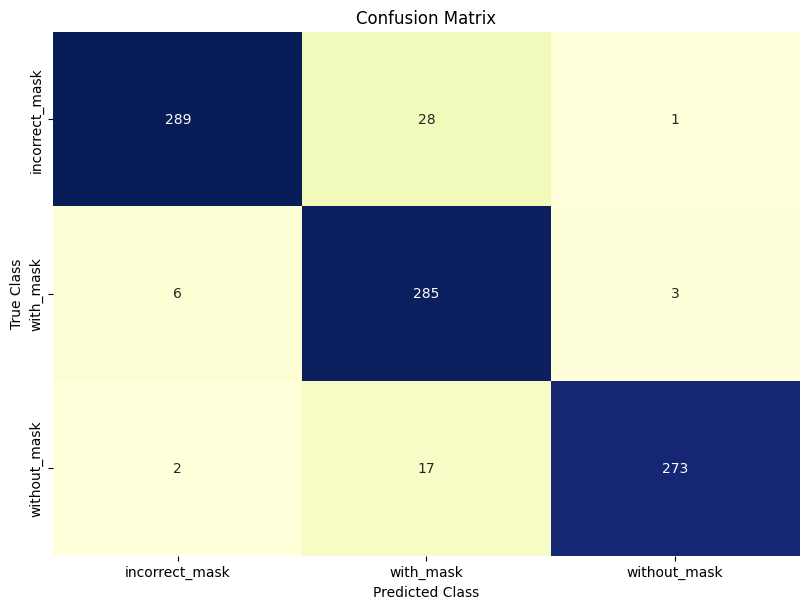

Epoch: 16, Training Loss: 0.1045, Train Accuracy = 0.9642, Validation Loss: 0.1549, Val Accuracy = 0.9369


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


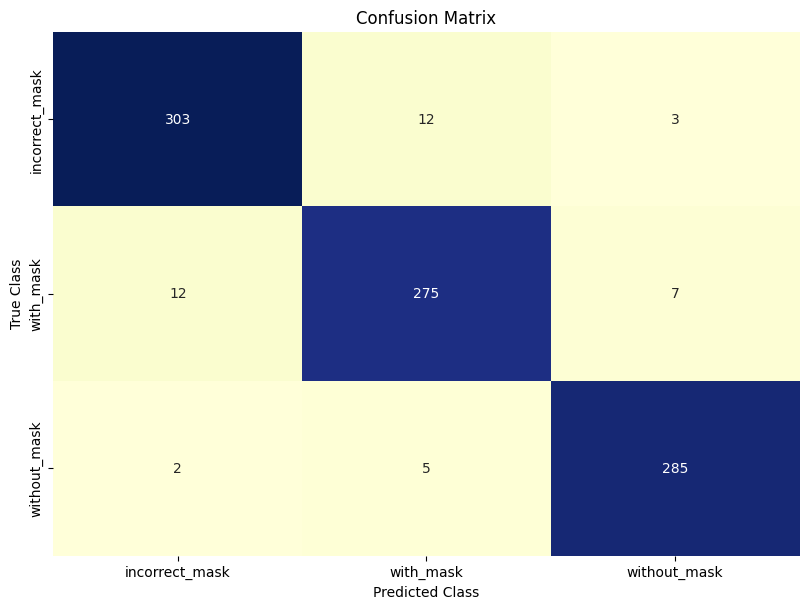

Epoch: 17, Training Loss: 0.1024, Train Accuracy = 0.9649, Validation Loss: 0.1199, Val Accuracy = 0.9546


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


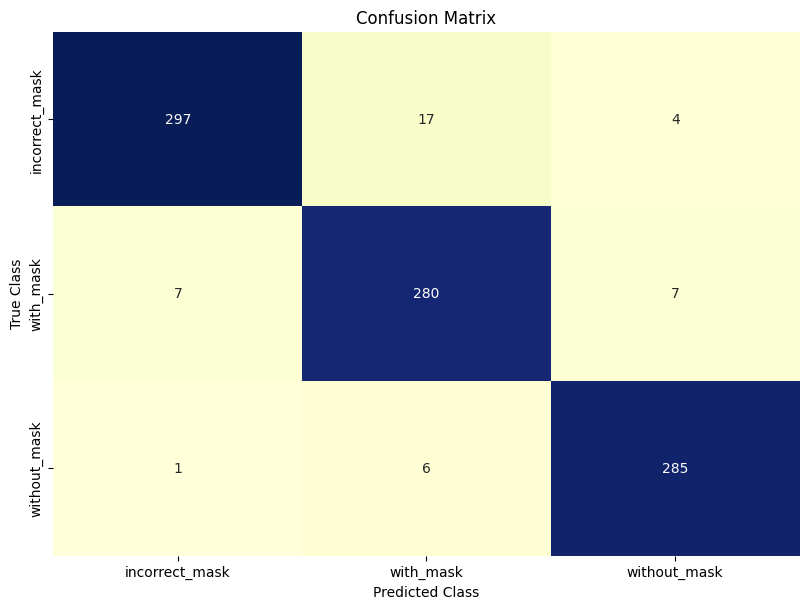

Epoch: 18, Training Loss: 0.0967, Train Accuracy = 0.9667, Validation Loss: 0.1242, Val Accuracy = 0.9535


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


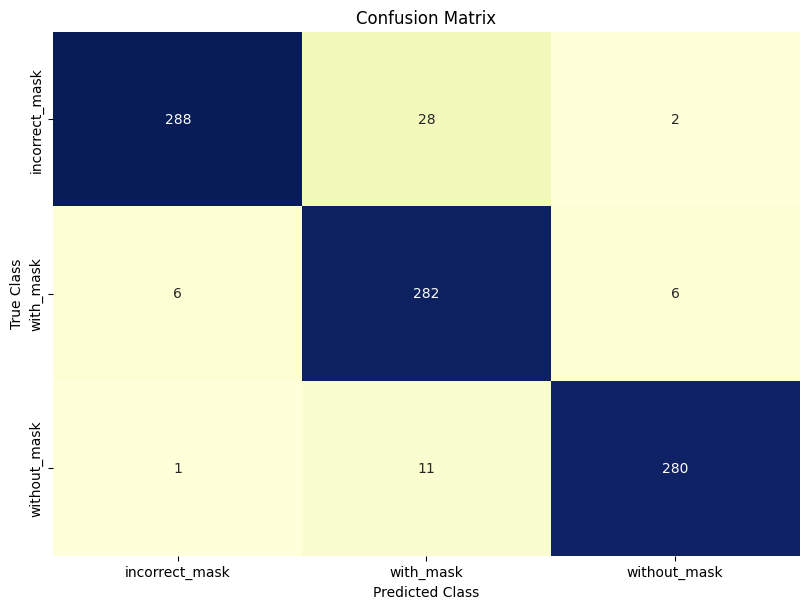

Epoch: 19, Training Loss: 0.0989, Train Accuracy = 0.9666, Validation Loss: 0.1424, Val Accuracy = 0.9403


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


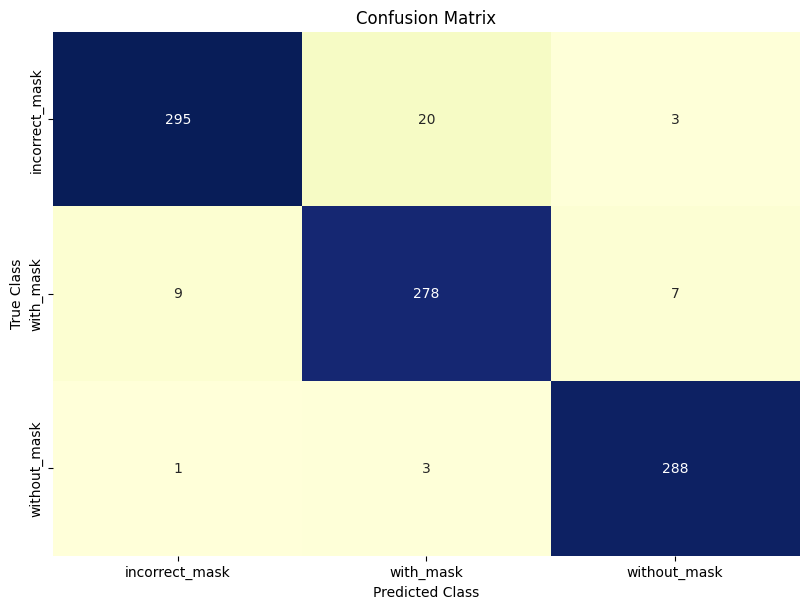

Epoch: 20, Training Loss: 0.0988, Train Accuracy = 0.9665, Validation Loss: 0.1250, Val Accuracy = 0.9524


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


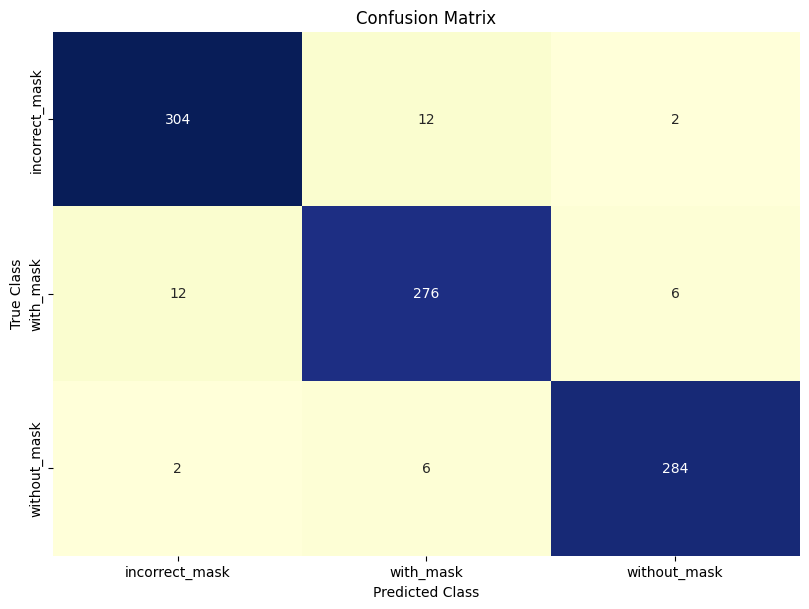

Epoch: 21, Training Loss: 0.1011, Train Accuracy = 0.9653, Validation Loss: 0.1233, Val Accuracy = 0.9558


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


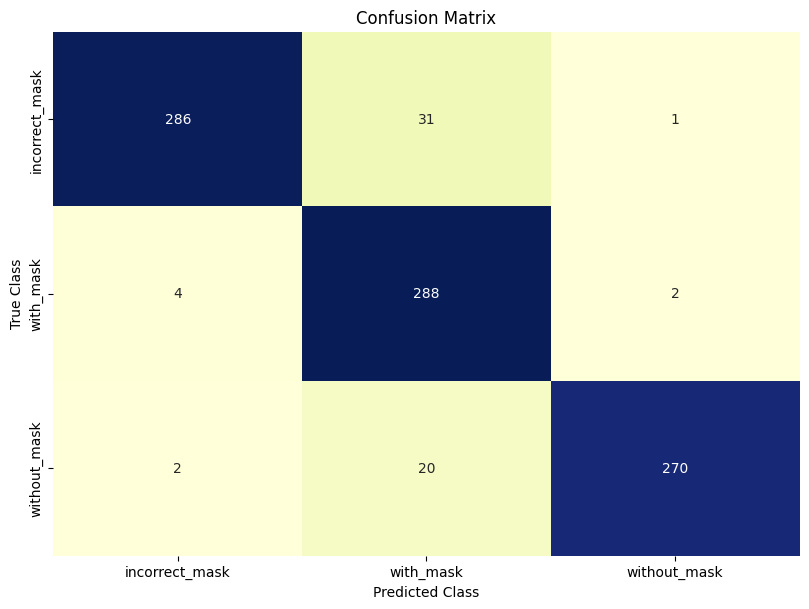

Epoch: 22, Training Loss: 0.1030, Train Accuracy = 0.9648, Validation Loss: 0.1611, Val Accuracy = 0.9336


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


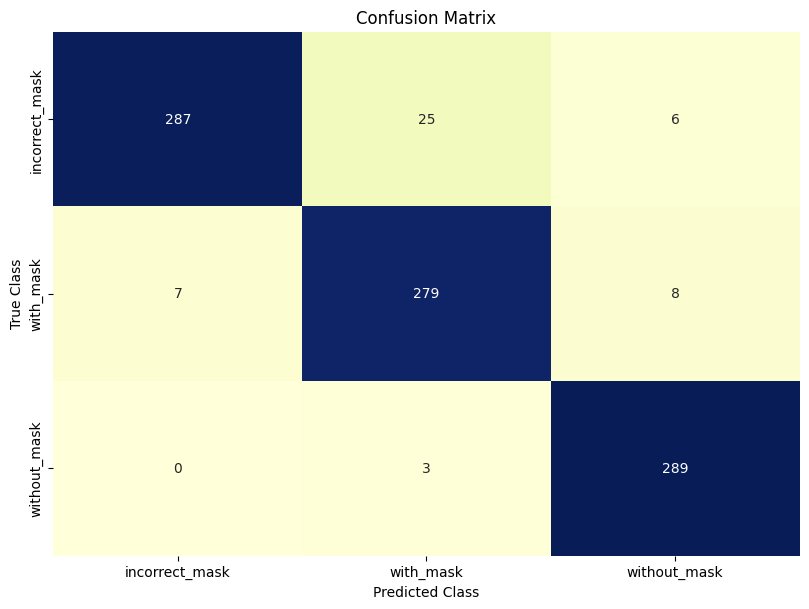

Epoch: 23, Training Loss: 0.0995, Train Accuracy = 0.9672, Validation Loss: 0.1450, Val Accuracy = 0.9458


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


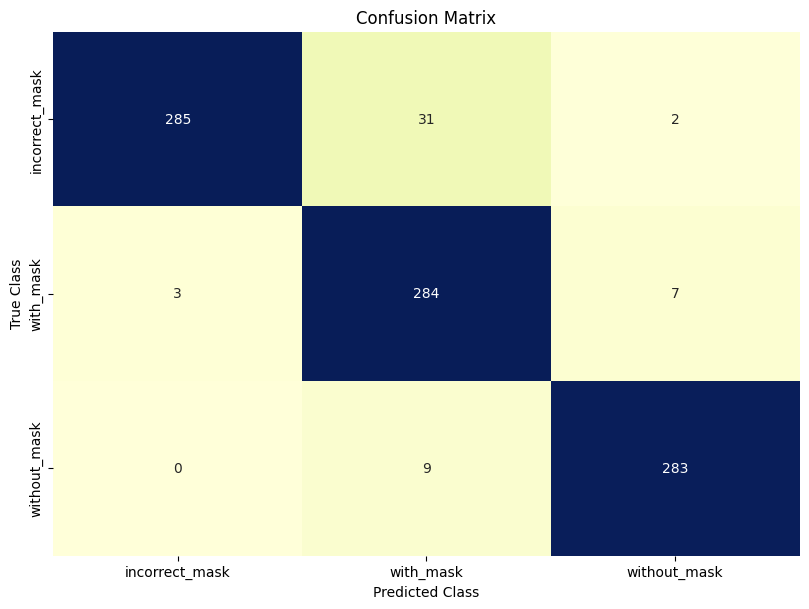

Epoch: 24, Training Loss: 0.0971, Train Accuracy = 0.9677, Validation Loss: 0.1602, Val Accuracy = 0.9425


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


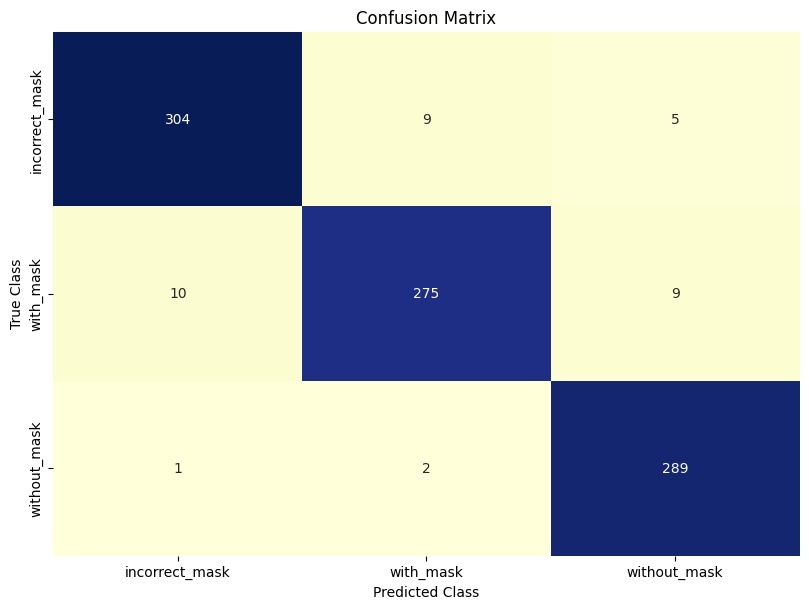

Epoch: 25, Training Loss: 0.0909, Train Accuracy = 0.9690, Validation Loss: 0.1251, Val Accuracy = 0.9602


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


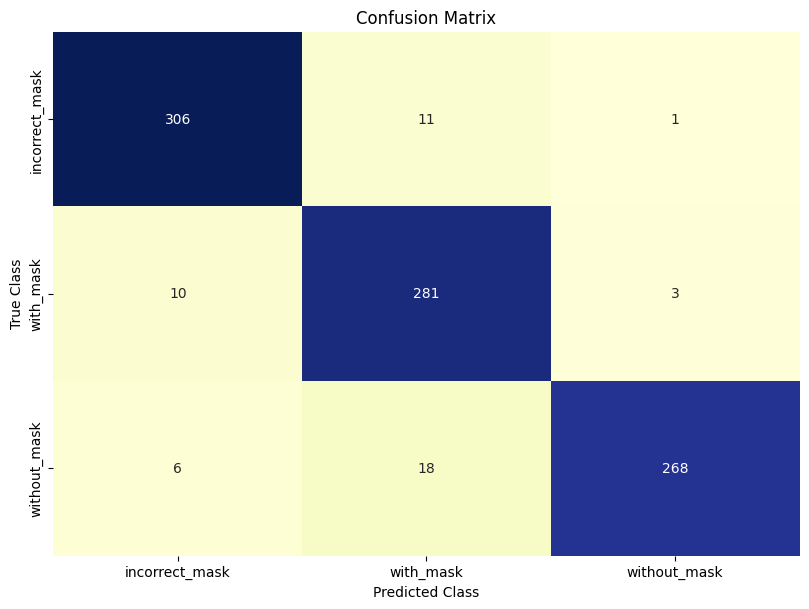

Epoch: 26, Training Loss: 0.0991, Train Accuracy = 0.9665, Validation Loss: 0.1433, Val Accuracy = 0.9458


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


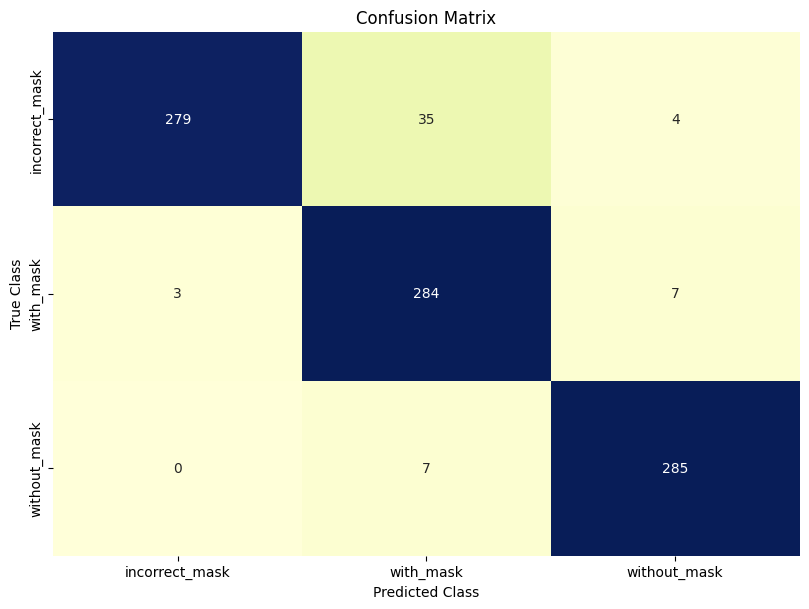

Epoch: 27, Training Loss: 0.0940, Train Accuracy = 0.9701, Validation Loss: 0.1734, Val Accuracy = 0.9381


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


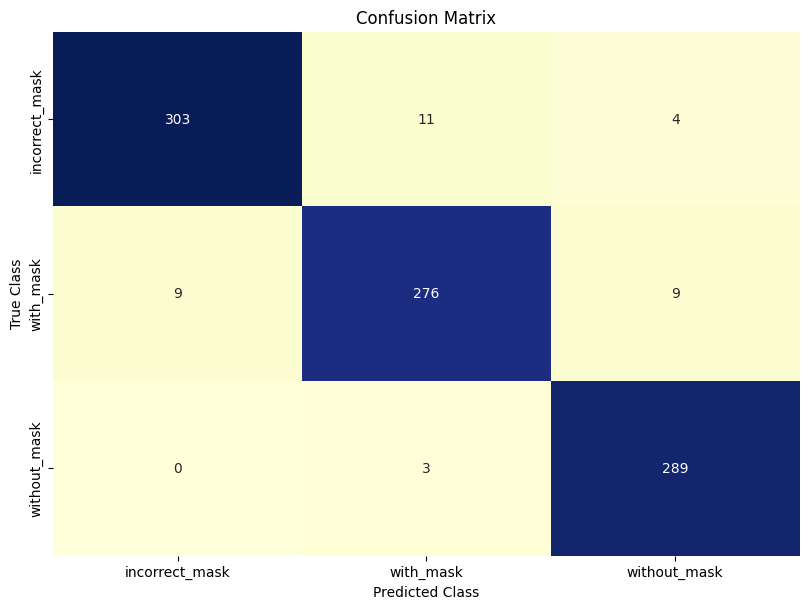

Epoch: 28, Training Loss: 0.0989, Train Accuracy = 0.9665, Validation Loss: 0.1241, Val Accuracy = 0.9602


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


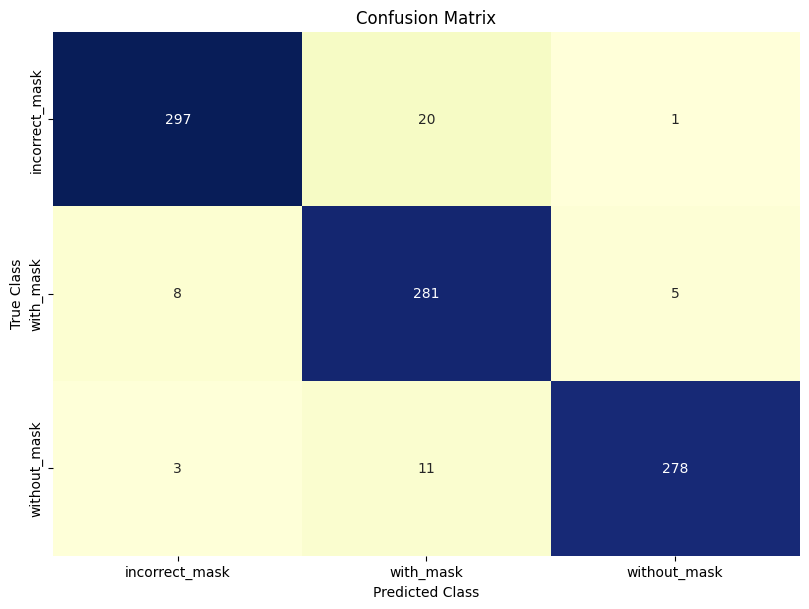

Epoch: 29, Training Loss: 0.0932, Train Accuracy = 0.9685, Validation Loss: 0.1349, Val Accuracy = 0.9469


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


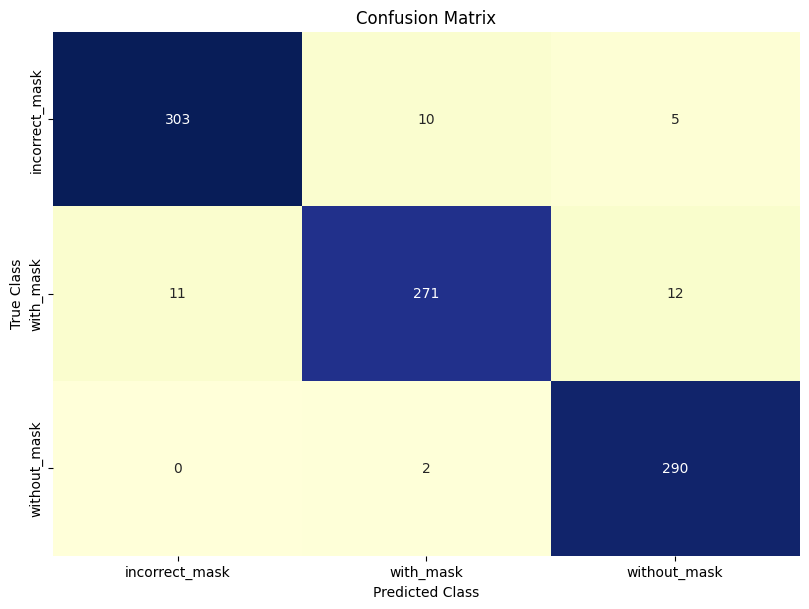

Epoch: 30, Training Loss: 0.0925, Train Accuracy = 0.9687, Validation Loss: 0.1226, Val Accuracy = 0.9558


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


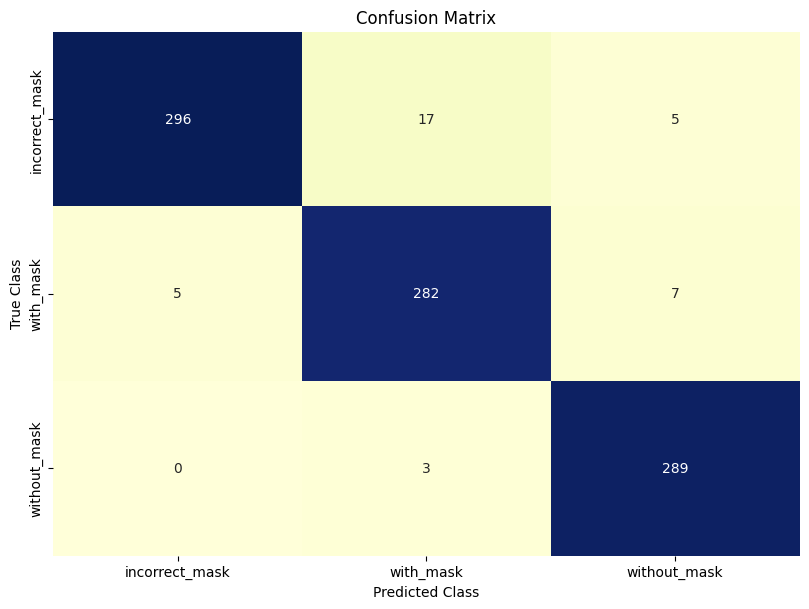

Epoch: 31, Training Loss: 0.0904, Train Accuracy = 0.9691, Validation Loss: 0.1343, Val Accuracy = 0.9591


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


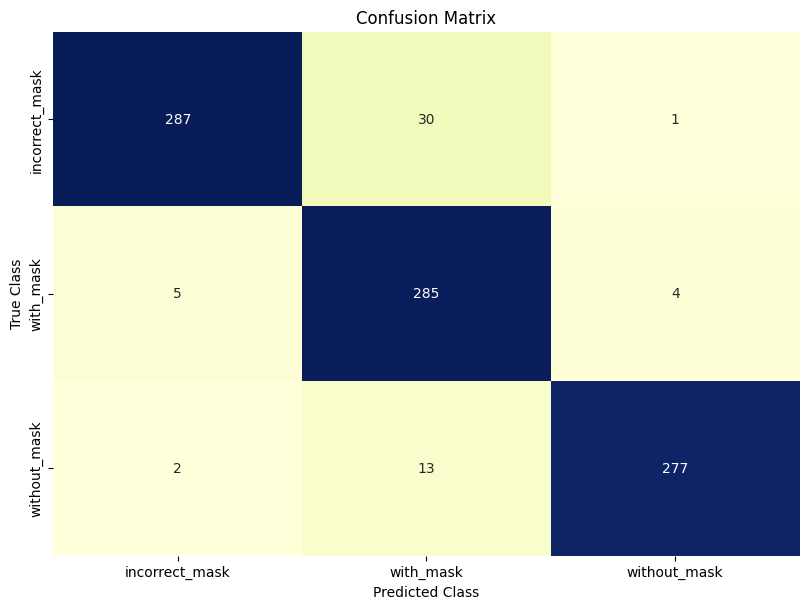

Epoch: 32, Training Loss: 0.0948, Train Accuracy = 0.9665, Validation Loss: 0.1535, Val Accuracy = 0.9392


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


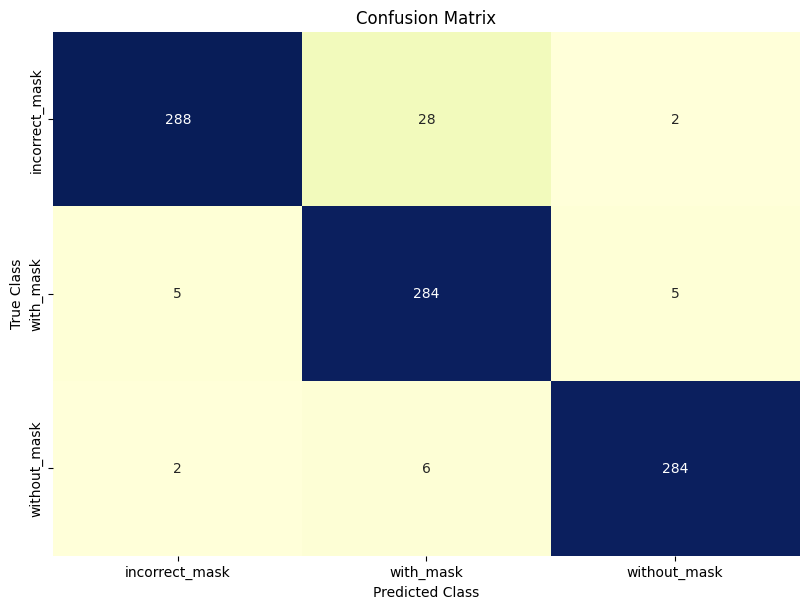

Epoch: 33, Training Loss: 0.0892, Train Accuracy = 0.9697, Validation Loss: 0.1418, Val Accuracy = 0.9469


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


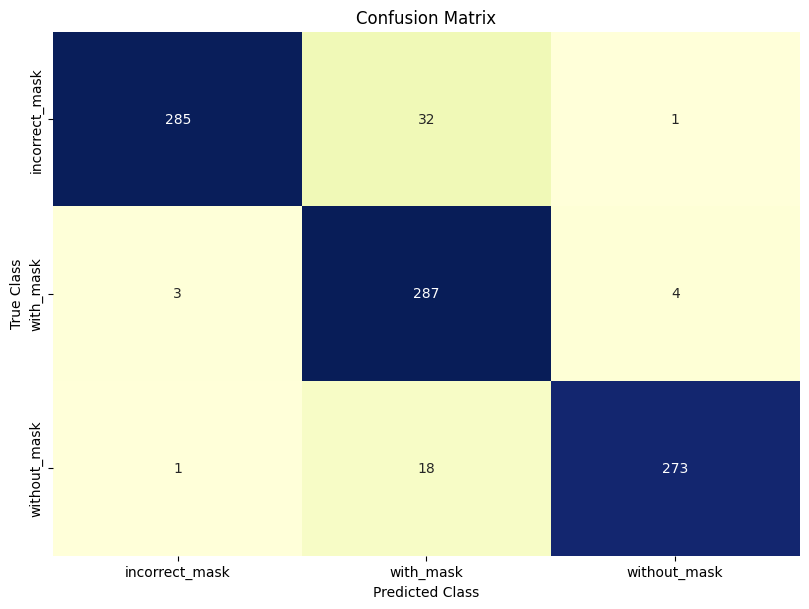

Epoch: 34, Training Loss: 0.0938, Train Accuracy = 0.9679, Validation Loss: 0.1703, Val Accuracy = 0.9347


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


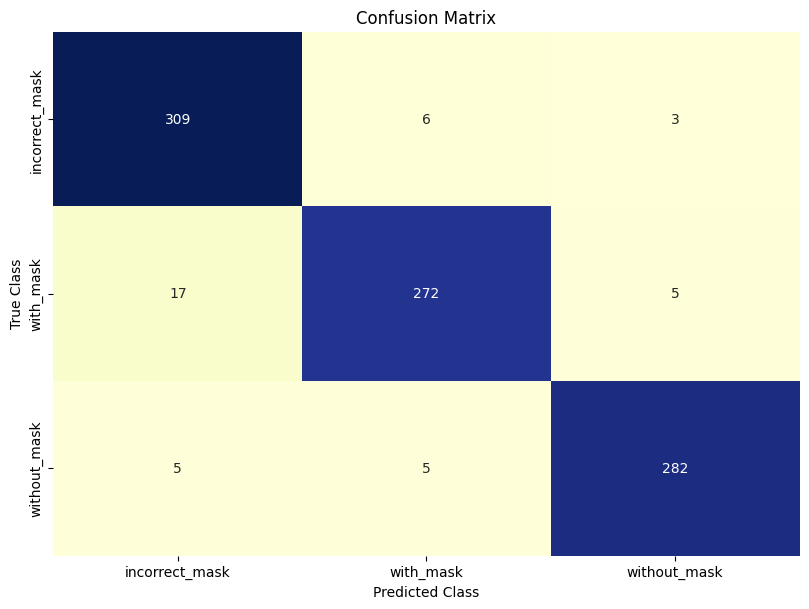

Epoch: 35, Training Loss: 0.0961, Train Accuracy = 0.9673, Validation Loss: 0.1290, Val Accuracy = 0.9546


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


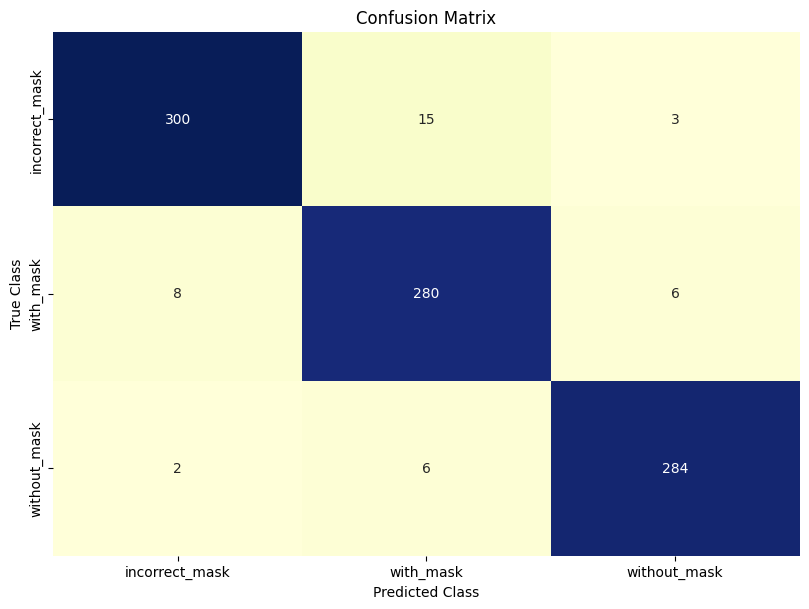

Epoch: 36, Training Loss: 0.0932, Train Accuracy = 0.9678, Validation Loss: 0.1274, Val Accuracy = 0.9558


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


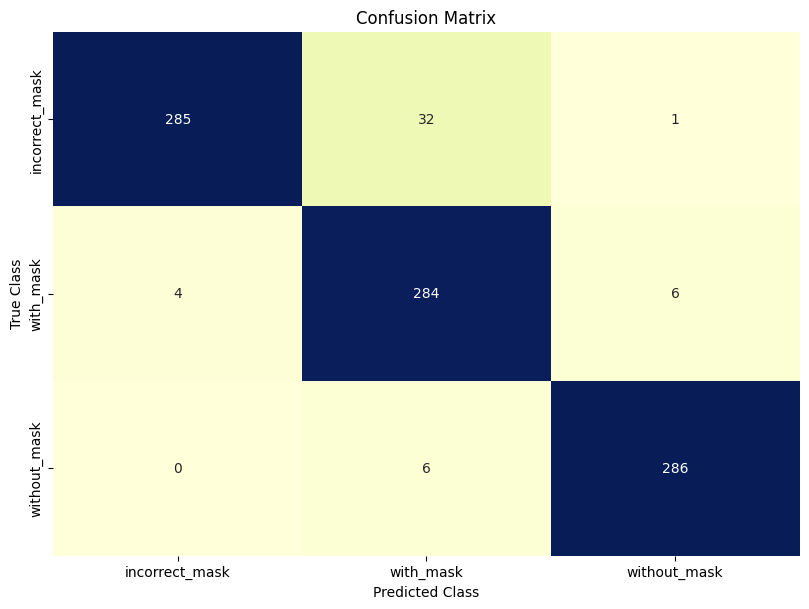

Epoch: 37, Training Loss: 0.0925, Train Accuracy = 0.9670, Validation Loss: 0.1608, Val Accuracy = 0.9458


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


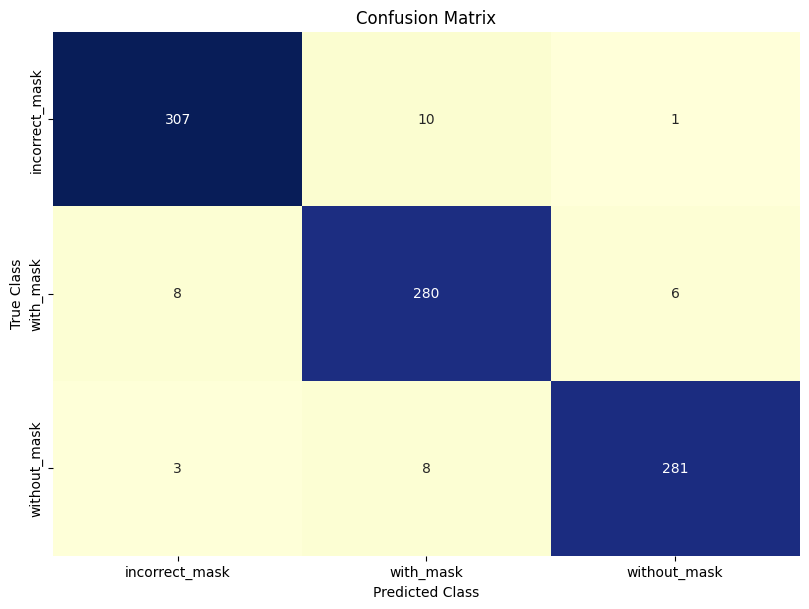

Epoch: 38, Training Loss: 0.0859, Train Accuracy = 0.9705, Validation Loss: 0.1248, Val Accuracy = 0.9602


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


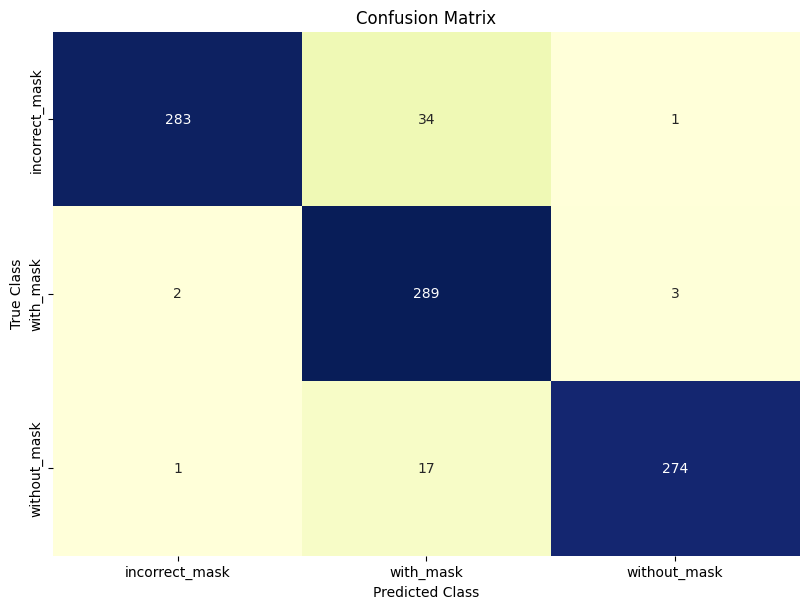

Epoch: 39, Training Loss: 0.0906, Train Accuracy = 0.9696, Validation Loss: 0.1688, Val Accuracy = 0.9358


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


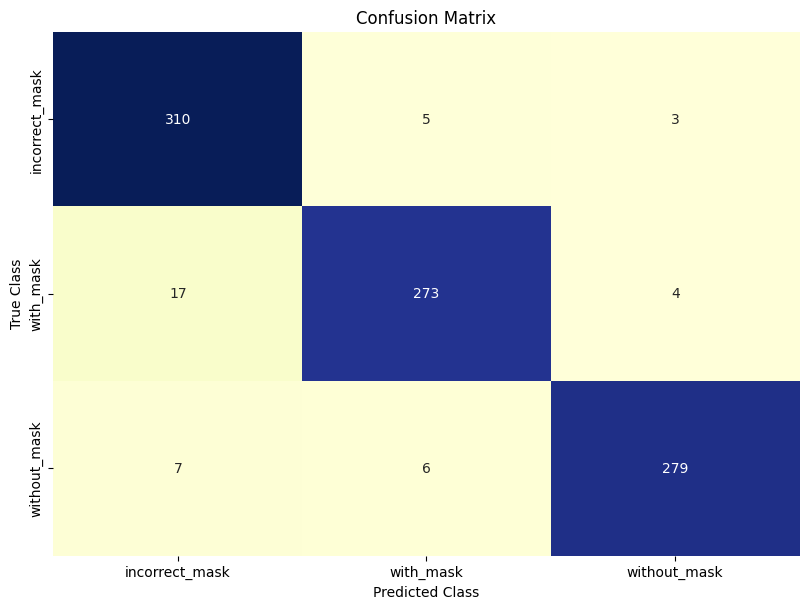

Epoch: 40, Training Loss: 0.0892, Train Accuracy = 0.9710, Validation Loss: 0.1328, Val Accuracy = 0.9535


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


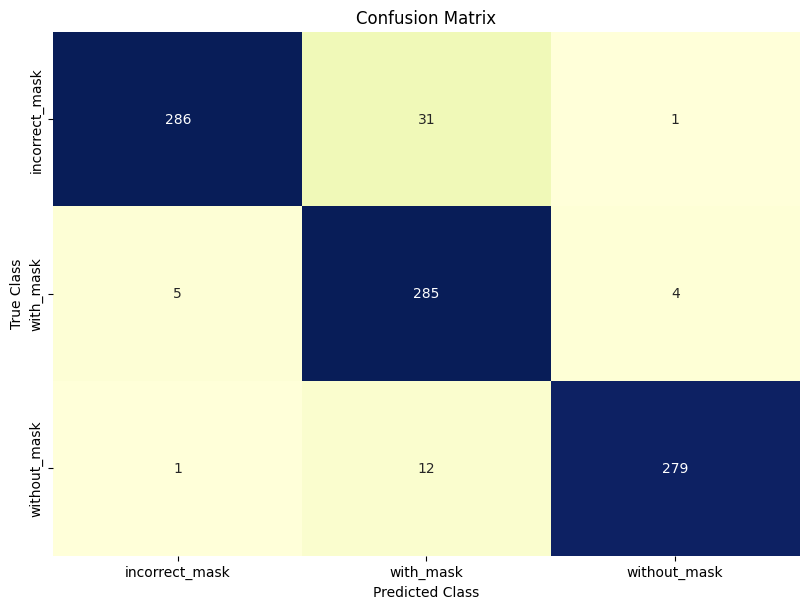

Epoch: 41, Training Loss: 0.0878, Train Accuracy = 0.9707, Validation Loss: 0.1557, Val Accuracy = 0.9403


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


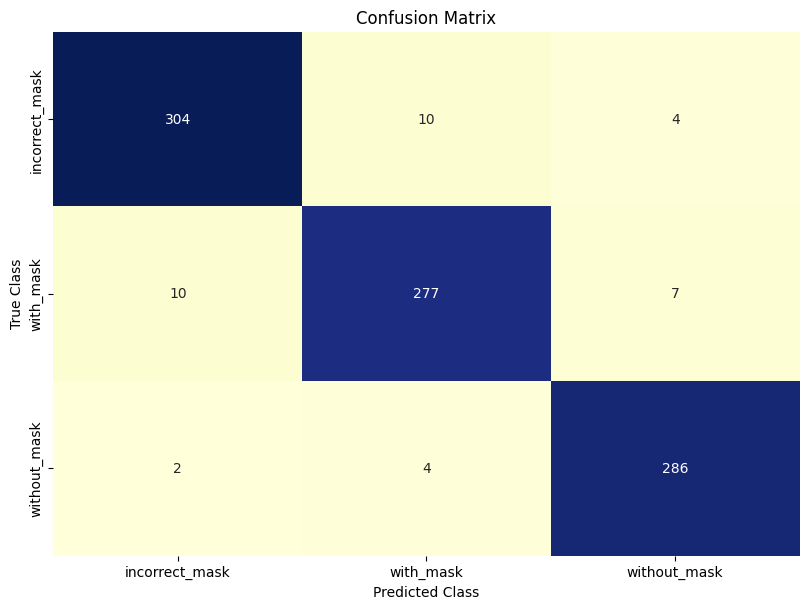

Epoch: 42, Training Loss: 0.0912, Train Accuracy = 0.9679, Validation Loss: 0.1225, Val Accuracy = 0.9591


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


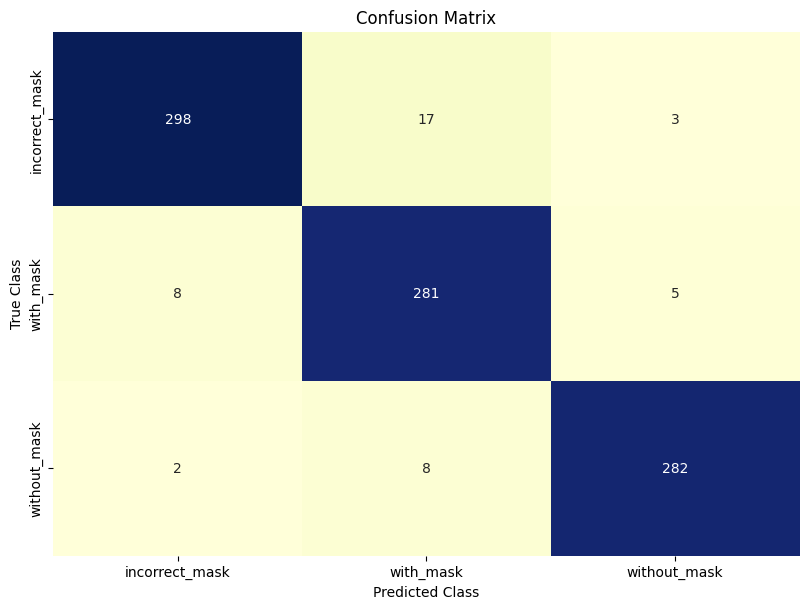

Epoch: 43, Training Loss: 0.0906, Train Accuracy = 0.9697, Validation Loss: 0.1347, Val Accuracy = 0.9524


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


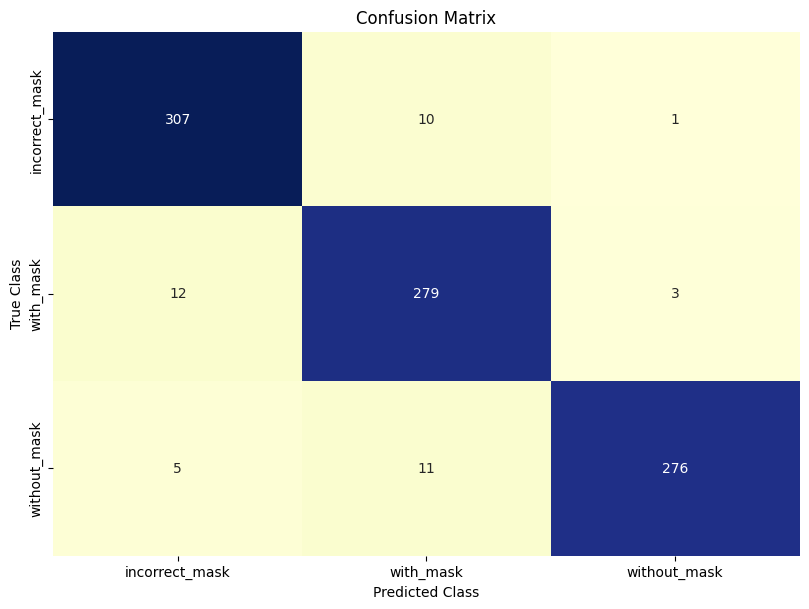

Epoch: 44, Training Loss: 0.0904, Train Accuracy = 0.9679, Validation Loss: 0.1390, Val Accuracy = 0.9535


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


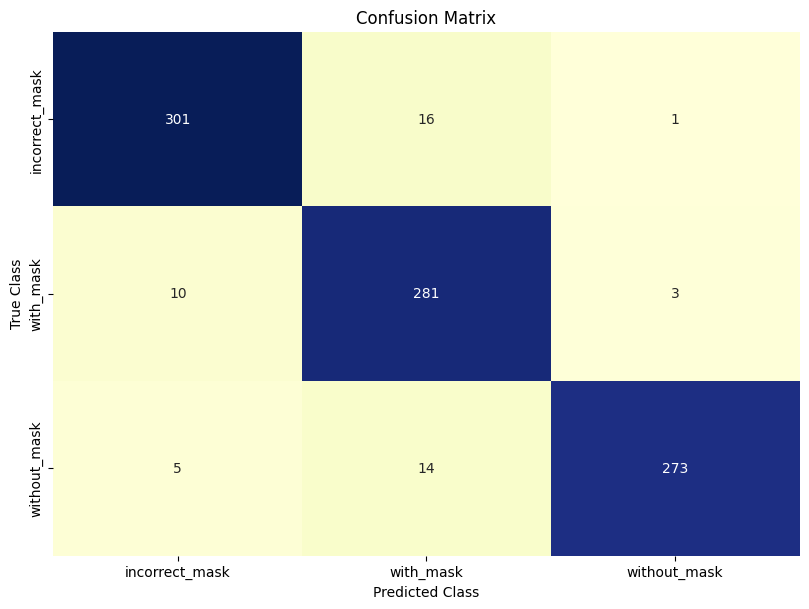

Epoch: 45, Training Loss: 0.0812, Train Accuracy = 0.9743, Validation Loss: 0.1414, Val Accuracy = 0.9458


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


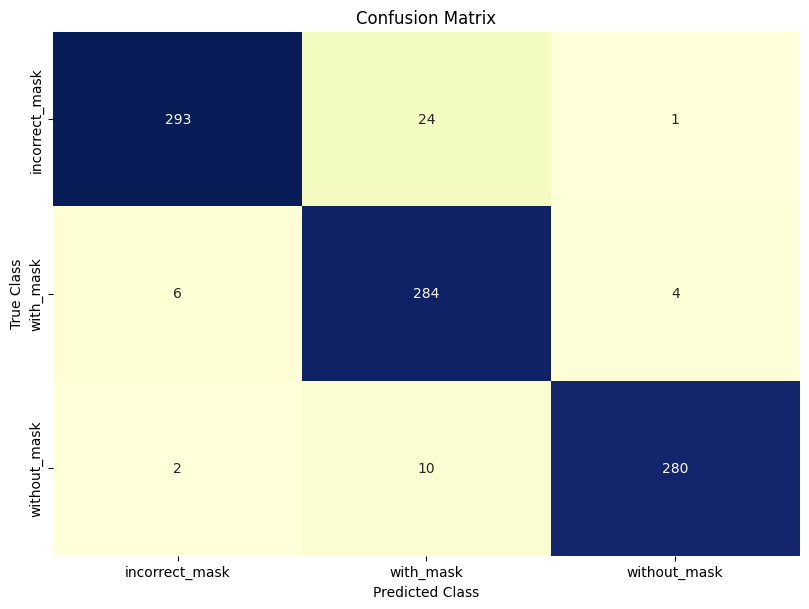

Epoch: 46, Training Loss: 0.0834, Train Accuracy = 0.9715, Validation Loss: 0.1460, Val Accuracy = 0.9480


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


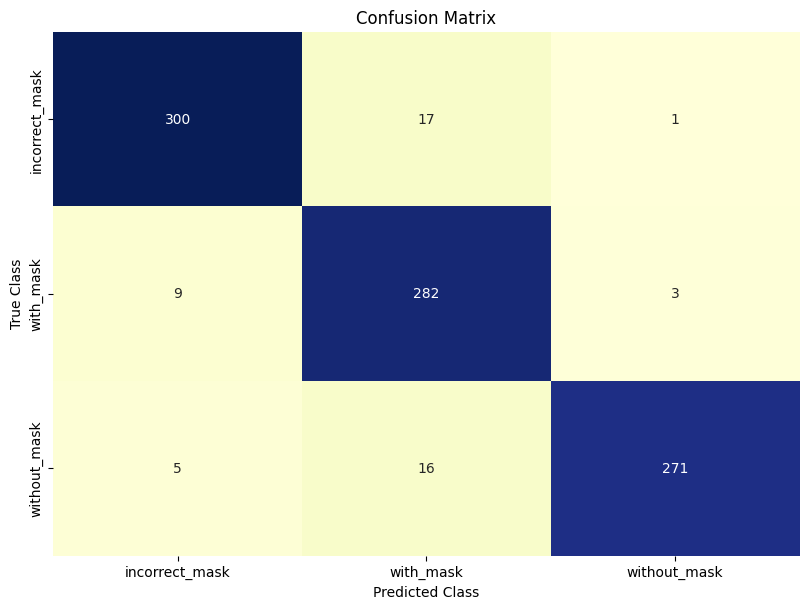

Epoch: 47, Training Loss: 0.0883, Train Accuracy = 0.9699, Validation Loss: 0.1478, Val Accuracy = 0.9436


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


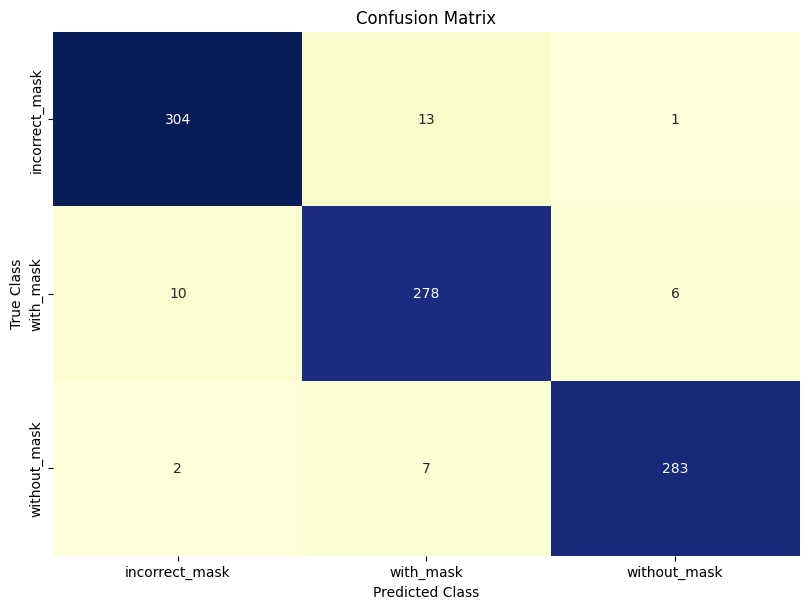

Epoch: 48, Training Loss: 0.0867, Train Accuracy = 0.9707, Validation Loss: 0.1241, Val Accuracy = 0.9569


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


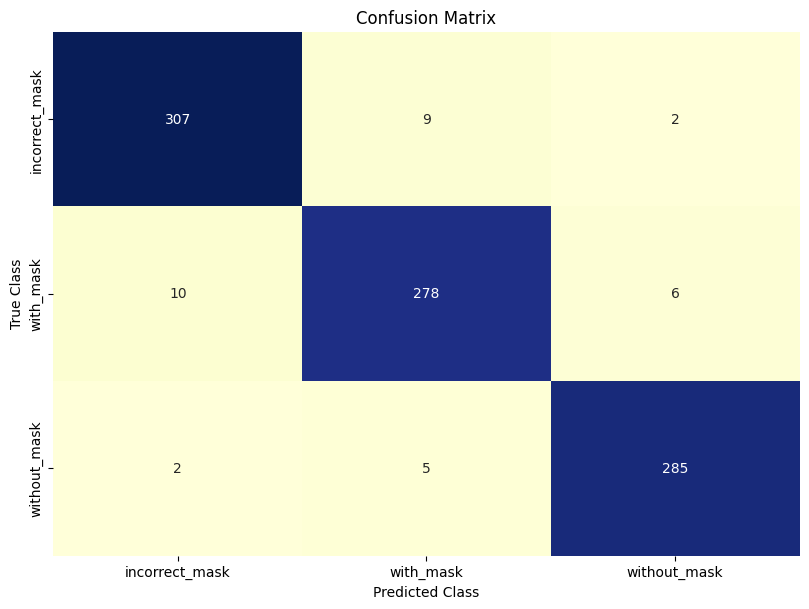

Epoch: 49, Training Loss: 0.0863, Train Accuracy = 0.9709, Validation Loss: 0.1198, Val Accuracy = 0.9624


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


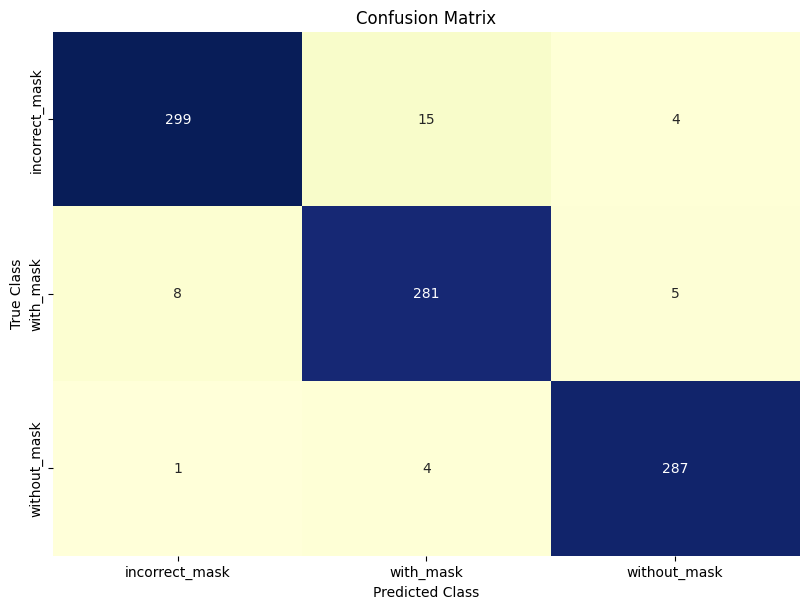

Epoch: 50, Training Loss: 0.0808, Train Accuracy = 0.9721, Validation Loss: 0.1280, Val Accuracy = 0.9591


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


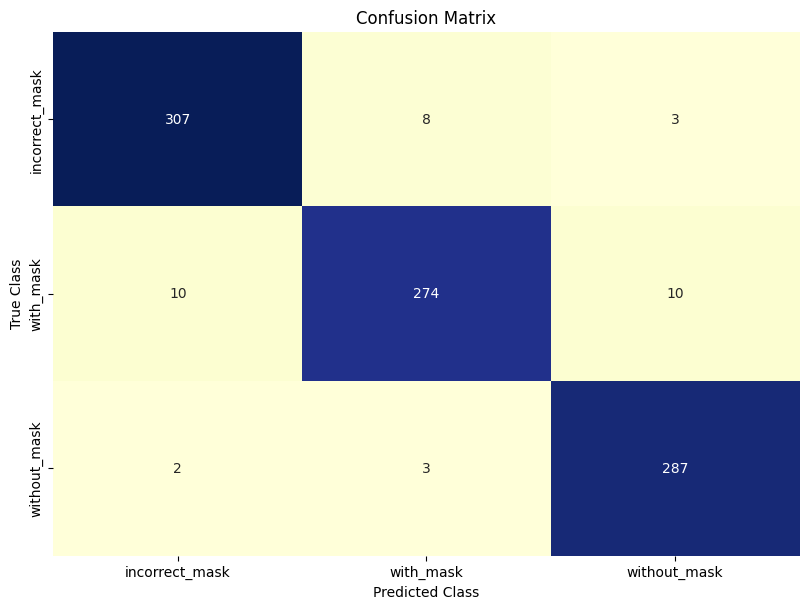

Epoch: 51, Training Loss: 0.0830, Train Accuracy = 0.9721, Validation Loss: 0.1228, Val Accuracy = 0.9602


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


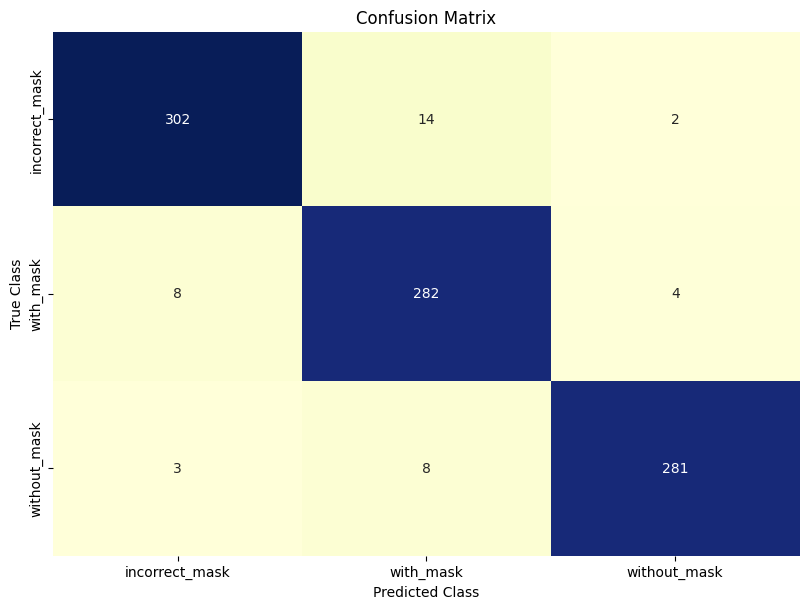

Epoch: 52, Training Loss: 0.0830, Train Accuracy = 0.9702, Validation Loss: 0.1271, Val Accuracy = 0.9569


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


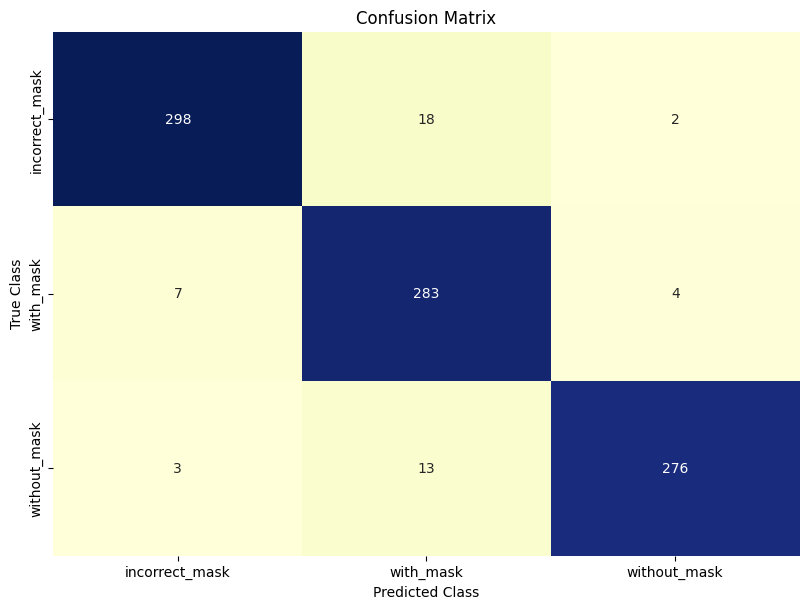

Epoch: 53, Training Loss: 0.0831, Train Accuracy = 0.9712, Validation Loss: 0.1420, Val Accuracy = 0.9480


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


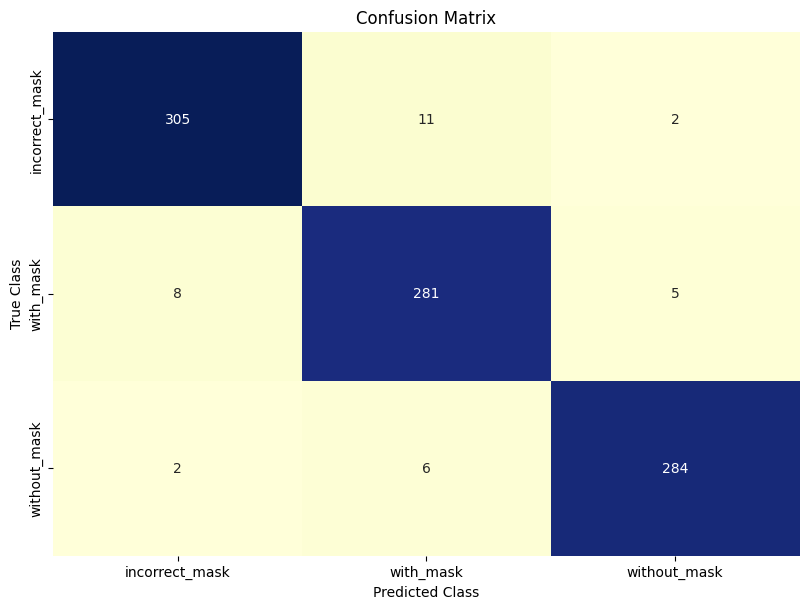

Epoch: 54, Training Loss: 0.0820, Train Accuracy = 0.9721, Validation Loss: 0.1245, Val Accuracy = 0.9624


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
#train the model first 100 epochs
train(model, optimizer,loss,dataloaders['train'],dataloaders['test'],100,device)

In [ ]:
#test the model
test_model(model)

In [ ]:
#save the model
torch.save(model, "./firstHundread.pth")